In [2]:
import pickle
import numpy as np
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from typing import List, Set, Tuple
from graph import Graph


In [3]:
# Load the whole data for statistics and mapping
with open('data/graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

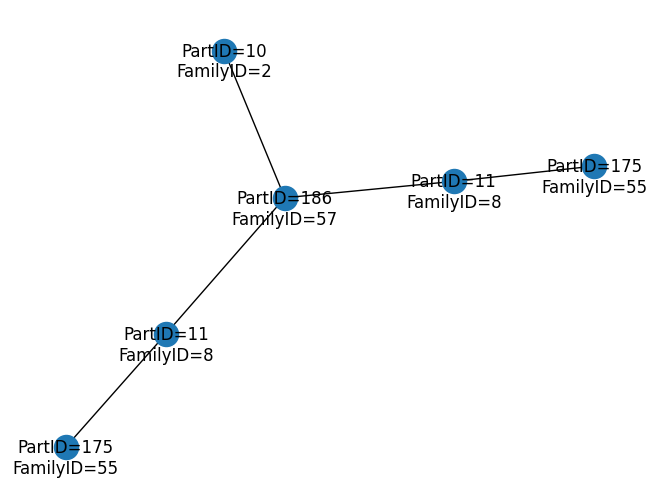

In [4]:
graphs[2].draw()

In [5]:
# Calculate some relevant statistics

max_part_id = -1 # 2270
max_family_id = -1 # 587

parts_set = set()

for graph in graphs:
    parts = graph.get_parts()
    for part in parts:
        parts_set.add(int(part.get_part_id()))
        max_part_id = max(int(part.get_part_id()), max_part_id)
        max_familiy_id = max(int(part.get_part_id()), max_family_id)


print(max_part_id)
print(max_familiy_id)

2270
587


In [6]:
## Make it dense (create mapping)
print(len(parts_set))
parts = list(parts_set)
parts.sort()

size = len(parts) + 1

parts_map = dict()

for new_id, old_id in enumerate(parts):
    parts_map[old_id] = new_id

print(parts_map)

# Create the reverse map, for easy lookup
parts_reverse_map = {v: k for k, v in parts_map.items()}

1081
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 25: 24, 27: 25, 28: 26, 29: 27, 30: 28, 31: 29, 33: 30, 35: 31, 36: 32, 37: 33, 38: 34, 40: 35, 41: 36, 42: 37, 43: 38, 44: 39, 45: 40, 46: 41, 47: 42, 48: 43, 49: 44, 50: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 57: 51, 58: 52, 60: 53, 61: 54, 62: 55, 63: 56, 64: 57, 65: 58, 66: 59, 67: 60, 68: 61, 69: 62, 70: 63, 71: 64, 72: 65, 73: 66, 74: 67, 75: 68, 76: 69, 77: 70, 78: 71, 79: 72, 80: 73, 81: 74, 82: 75, 83: 76, 84: 77, 85: 78, 86: 79, 87: 80, 88: 81, 90: 82, 92: 83, 93: 84, 95: 85, 96: 86, 97: 87, 98: 88, 99: 89, 100: 90, 101: 91, 102: 92, 103: 93, 104: 94, 105: 95, 106: 96, 107: 97, 108: 98, 109: 99, 111: 100, 112: 101, 113: 102, 114: 103, 115: 104, 116: 105, 117: 106, 118: 107, 119: 108, 120: 109, 121: 110, 122: 111, 123: 112, 125: 113, 127: 114, 128: 115, 129: 116, 130: 117, 131: 118, 134: 119, 136:

In [7]:
# Switch to use training data only
with open('data/train_graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.,

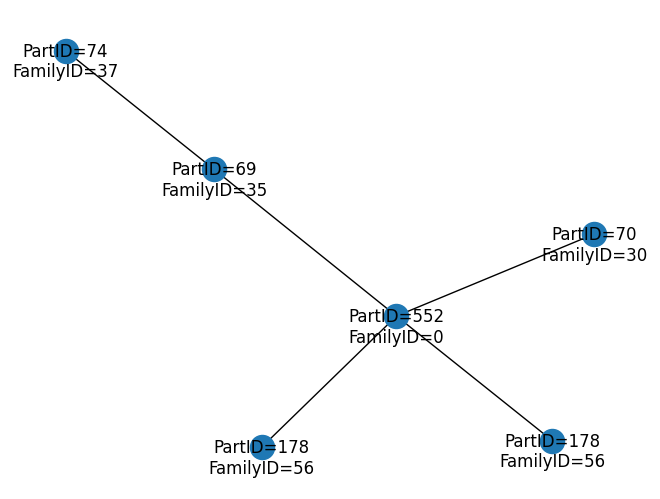

In [18]:
features = []

targets = []

for graph in graphs:

    # Feature 1: One-hot encoded graph

    part_ids_graph = graph.get_parts()

    part_ids_graph = [parts_map[int(part.get_part_id())] for part in part_ids_graph]

    feature_graph = torch.zeros(size, dtype=torch.float)

    for part_id in part_ids_graph:
        feature_graph[part_id] += 1
    

    edges = graph.get_edges()

    for source_node, target_nodes in edges.items():
        source_id = int(source_node.get_part().get_part_id())
        source_id = parts_map[source_id]

        # One-hot encode the source_id with pytorch tensors
        feature_source_id = torch.zeros(size, dtype=torch.float)
        feature_source_id[source_id] = 1

        target = torch.zeros(size, dtype=torch.float)
        for target_node in target_nodes:
            target_id = int(target_node.get_part().get_part_id())
            target_id = parts_map[target_id]
            
            target[target_id] = 1

        targets.append(target)
        features.append(torch.stack([feature_graph, feature_source_id]))

torch.set_printoptions(profile="full")        
print(features[0])
graphs[0].draw()

In [9]:
print(len(features))
print(len(targets))

68179
68179


In [12]:
## Create the Model

class FFNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FFNModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 2048)
        self.fc2 = nn.Linear(2048, 4096)
        self.fc3 = nn.Linear(4096, 4096)
        self.fc4 = nn.Linear(4096, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x



model = FFNModel(size * 2, size)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
## Prepare the data for training

# Split data inot train, validation and test (60%, 20%, 20%) without libary

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42, shuffle=False)

## Create the DataLoader

train_data = TensorDataset(torch.stack(X_train), torch.stack(y_train))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(torch.stack(X_test), torch.stack(y_test))
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


In [15]:
## Traing process
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    # Evaluation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
    print(f'Test Loss: {test_loss/len(test_loader)}')

Epoch 1/50, Loss: 0.0003242606730449568
Test Loss: 0.0007696749727804926
Epoch 2/50, Loss: 0.00029038538445055515
Test Loss: 0.0006295791179207137
Epoch 3/50, Loss: 0.00027185996786451293
Test Loss: 0.000623148056475088
Epoch 4/50, Loss: 0.0002487510651914879
Test Loss: 0.0006822201878447921
Epoch 5/50, Loss: 0.00023793014188480186
Test Loss: 0.000651132944422542
Epoch 6/50, Loss: 0.0002293233283588777
Test Loss: 0.0006103171342575229
Epoch 7/50, Loss: 0.0002316837971685396
Test Loss: 0.0006506529210642451
Epoch 8/50, Loss: 0.000214021440750888
Test Loss: 0.000649479411705179
Epoch 9/50, Loss: 0.00021124933793635535
Test Loss: 0.0006677360229372344


KeyboardInterrupt: 

In [45]:
# Save the model
torch.save(model.state_dict(), 'edge_prediction_model.pth')

In [37]:
with open('data/test_graphs.dat', 'rb') as file:
    graphs: List[Graph] = pickle.load(file)

graph = graphs[48]

In [38]:
def create_input_tensor(graph: Graph, part_id: int) -> torch.Tensor:

    part_ids_graph = graph.get_parts()

    part_ids_graph = [parts_map[int(part.get_part_id())] for part in part_ids_graph]

    feature_graph = torch.zeros(size, dtype=torch.float)

    for part_id in part_ids_graph:
        feature_graph[part_id] = 1
    

    feature_source_id = torch.zeros(size, dtype=torch.float)
    feature_source_id[part_id] = 1
    
    return torch.stack([feature_graph, feature_source_id])
    

In [39]:
def predict(model, input_tensor):
    model.eval()  # Set to evaluation mode
    with torch.no_grad():
        # Add batch dimension and flatten the input
        x = input_tensor.unsqueeze(0)  # Add batch dimension
        x = x.view(1, -1)  # Flatten to (1, input_size)
        output = model(x)
        return output.squeeze(0)  # Remove batch dimension from output

# Example usage:
print(graph.get_parts())
input_tensor = create_input_tensor(graph, parts_map[60])
prediction = predict(model, input_tensor)

# If you want to get the most likely edges (e.g., top k predictions)
k = 5  # Number of predictions to return
values, indices = torch.topk(prediction, k)
print(f"Top {k} predicted connections:")
for value, idx in zip(values, indices):
    print(f"Part ID {idx}: probability {value:.4f}")

{Part(PartID=265, FamilyID=0), Part(PartID=270, FamilyID=56), Part(PartID=4, FamilyID=3), Part(PartID=533, FamilyID=1), Part(PartID=270, FamilyID=56)}
Top 5 predicted connections:
Part ID 228: probability 0.9772
Part ID 337: probability 0.0029
Part ID 252: probability 0.0028
Part ID 504: probability 0.0012
Part ID 816: probability 0.0006


In [80]:
# Calculate the matrix of probabilities
part_ids = [parts_map[int(part.get_part_id())] for part in graph.get_parts()]
part_id_set = set(part_ids)
print(part_id_set)

# Create a matrix to store the probabilities (dictionary of dictionaries)
probabilities = {part_id: {} for part_id in part_id_set}

for part_id in part_id_set:
    input_tensor = create_input_tensor(graph, part_id)
    prediction = predict(model, input_tensor)
    # Only store the probabilites that are in the part_ids set
    for idx, prob in enumerate(prediction):
        if idx in part_ids and idx != part_id:
            probabilities[part_id][idx] = prob.item()
    
# Apply the reverse mapping to the probabilities
new_probabilities = {}
for part_id, probs in probabilities.items():
    new_probs = {}
    for target_id, prob in probs.items():
        new_probs[parts_reverse_map[target_id]] = prob
    new_probabilities[parts_reverse_map[part_id]] = new_probs

probabilities = new_probabilities

# Find the top connections
connections = []
for part_id, probs in probabilities.items():
    for target_id, prob in probs.items():
        connections.append((part_id, target_id, prob))

sorted_connections = sorted(connections, key=lambda x: x[2], reverse=True)
   

print(sorted_connections)

# Print top connections with more detail
print("\nTop connections (showing only unique pairs):")
for part_id, target_id, prob in sorted_connections:
    print(f"Connection between Part {part_id} and Part {target_id}: {prob:.6f}")

#Print the top 10 connections
for part_id, target_id, prob in sorted_connections[:10]:
    print(f"Part ID {part_id} -> Part ID {target_id}: probability {prob:.4f}")

# # Print the top 10 connections  with reverse mapping applied
# for part_id, target_id, prob in sorted_connections[:10]:
#     print(f"Part ID {parts_reverse_map[part_id]} -> Part ID {parts_reverse_map[target_id]}: probability {prob:.10f}")


print(probabilities)

{232, 228, 4, 423}
[(270, 265, 0.977196455001831), (4, 265, 0.977196455001831), (533, 265, 0.977196455001831), (270, 533, 1.7888047523229034e-06), (265, 533, 1.7888047523229034e-06), (4, 533, 1.7888047523229034e-06), (270, 4, 1.9070419909894554e-08), (265, 4, 1.9070419909894554e-08), (533, 4, 1.9070419909894554e-08), (265, 270, 9.773257897416343e-11), (4, 270, 9.773257897416343e-11), (533, 270, 9.773257897416343e-11)]

Top connections (showing only unique pairs):
Connection between Part 270 and Part 265: 0.977196
Connection between Part 4 and Part 265: 0.977196
Connection between Part 533 and Part 265: 0.977196
Connection between Part 270 and Part 533: 0.000002
Connection between Part 265 and Part 533: 0.000002
Connection between Part 4 and Part 533: 0.000002
Connection between Part 270 and Part 4: 0.000000
Connection between Part 265 and Part 4: 0.000000
Connection between Part 533 and Part 4: 0.000000
Connection between Part 265 and Part 270: 0.000000
Connection between Part 4 and Pa

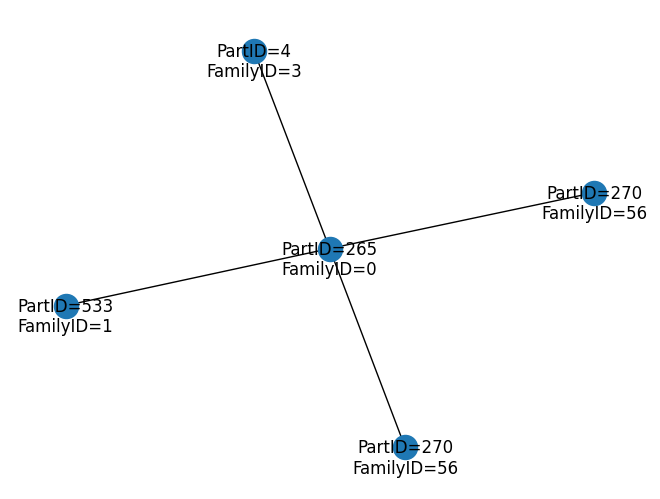

In [41]:
graph.draw()

In [76]:
## Greedy create the graph

new_graph = Graph()



{265: [Part(PartID=265, FamilyID=0)], 270: [Part(PartID=270, FamilyID=56), Part(PartID=270, FamilyID=56)], 4: [Part(PartID=4, FamilyID=3)], 533: [Part(PartID=533, FamilyID=1)]}


NameError: name 'Graph' is not defined

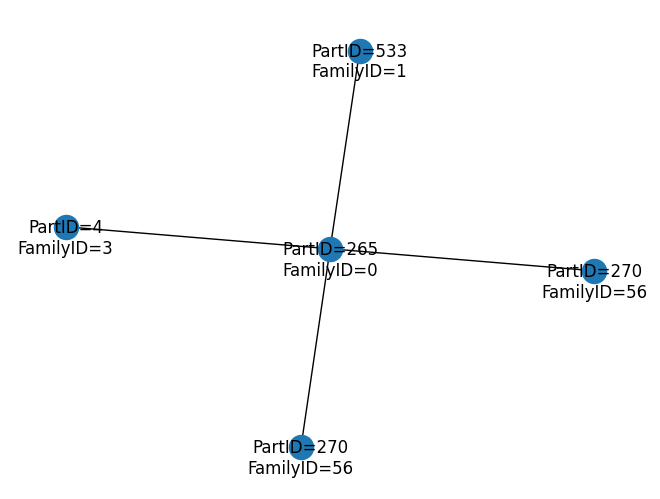

In [62]:
graph.draw()